In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline
sns.set()

In [2]:
X = pd.read_csv("/Users/panzichen/Columbia Term2 Courses/ML for DS/HW2/X.csv", header = None)
y = pd.read_csv("/Users/panzichen/Columbia Term2 Courses/ML for DS/HW2/y.csv", header = None)

In [3]:
print(len(X), len(y))

4600 4600


In [4]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,0,6,6,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,8,0,0
1,2,3,5,0,1,3,2,1,0,9,...,0,0,0,0,0,1,0,4,2,0
2,1,0,7,0,12,2,2,1,6,3,...,1,1,0,0,0,1,0,3,2,0
3,0,0,0,0,6,0,3,6,3,6,...,0,0,0,0,0,1,0,1,0,0
4,0,0,0,0,6,0,3,6,3,6,...,0,0,0,0,0,1,0,1,0,0


### Question a

In [5]:
X_array = np.array(X)
y_array = np.array(y)
X_array.shape

(4600, 54)

In [6]:
from sklearn.model_selection import KFold

def partition(X_array, y_array):
    kf = KFold(n_splits=10, shuffle = True)
    X_train_list = []
    X_test_list = []
    y_train_list = []
    y_test_list = []
    for train_index, test_index in kf.split(X_array):
        X_train, X_test = X_array[train_index], X_array[test_index]
        y_train, y_test = y_array[train_index], y_array[test_index]
        
        X_train_list.append(X_train)
        X_test_list.append(X_test)
        y_train_list.append(y_train)
        y_test_list.append(y_test)
    
    assert len(X_train_list) == 10
    
    return X_train_list, y_train_list, X_test_list, y_test_list

In [7]:
def cal_lamda(X_train, y_train):
    lamda = np.zeros(shape = (2,54))

    for yi in range(2):
        for d in range(54):
            
            if yi == 0:
                lamda[yi][d] = (1 + np.sum(np.multiply(X_train[:, d].reshape(-1, 1), 1 - y_train))) / \
                               (1 + np.sum(1 - y_train))
            
            else:
                lamda[yi][d] = (1 + np.sum(np.multiply(X_train[:, d].reshape(-1, 1), y_train))) / \
                               (1 + np.sum(y_train))
    return lamda

In [8]:
def cal_likelihood(X_test, y_test, lamda):
    
    n = len(X_test)
    likelihood = np.zeros(shape = (n, 2))
    
    for xi in range(n):

        for yi in range(2):

            if yi == 1: likelihood[xi][yi] = np.sum(y_test) / n
            else: likelihood[xi][yi] = np.sum(1 - y_test) / n

            for d in range(54):
                likelihood[xi][yi] *= np.exp(-lamda[yi][d]) * np.power(lamda[yi][d], X_test[xi][d])

                # factorial
                k = X_test[xi][d]
                while k > 1: 
                    likelihood[xi][yi] /= k
                    k -= 1
    return likelihood
        

In [9]:
def cal_metric(likelihood, y_test):
    y_predict = (likelihood[:,1].reshape(-1,1) > likelihood[:,0].reshape(-1,1)) * 1
    metric = pd.DataFrame(np.concatenate((y_test, y_predict), axis = 1), columns = ['y', 'y_predict'])
    
    TP = len(metric[(metric['y'] == 1) & (metric['y_predict'] == 1)])
    TN = len(metric[(metric['y'] == 0) & (metric['y_predict'] == 0)])
    FP = len(metric[(metric['y'] == 0) & (metric['y_predict'] == 1)])
    FN = len(metric[(metric['y'] == 1) & (metric['y_predict'] == 0)])
    #print("TP,TN,FP,FN:",TP,TN,FP,FN)
    return TP, TN, FP, FN

In [10]:
# cross validation
X_train_list, y_train_list, X_test_list, y_test_list = partition(X_array, y_array)
TP_list = []
TN_list = []
FP_list = []
FN_list = []
lamda_list = []

for i in range(10):
    X_train, y_train, X_test, y_test = X_train_list[i], y_train_list[i], X_test_list[i], y_test_list[i]
    lamda = cal_lamda(X_train, y_train)
    lamda_list.append(lamda)
    likelihood = cal_likelihood(X_test, y_test, lamda)
    TP, TN, FP, FN = cal_metric(likelihood, y_test)
    TP_list.append(TP)
    TN_list.append(TN)
    FP_list.append(FP)
    FN_list.append(FN)

/Users/panzichen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in power
  


In [11]:
TP = np.sum(TP_list)
TN = np.sum(TN_list)
FP = np.sum(FP_list)
FN = np.sum(FN_list)
assert TP + TN + FP + FN == 4600
accuracy = (TP + TN) / 4600
print("TP, TN, FP, FN, accuracy", TP, TN, FP, FN, accuracy)

TP, TN, FP, FN, accuracy 1703 2297 490 110 0.8695652173913043


### Question b

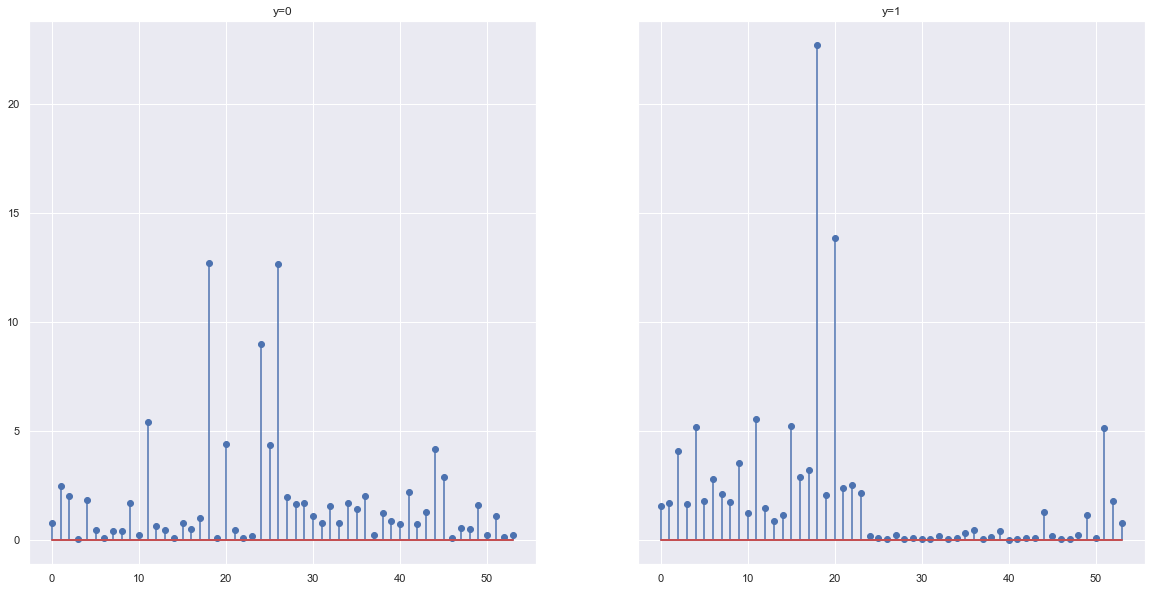

In [12]:
plot_x = list(range(54))
lamda_array = np.mean(lamda_list, axis = 0)
y0_lamda = list(lamda_array[0,:])
y1_lamda = list(lamda_array[1,:])

fig, ax = plt.subplots(1,2, figsize=(20, 10), sharey = True)
markerline, stemlines, baseline = ax[0].stem(plot_x, y0_lamda)
_ = plt.setp(baseline, color='r', linewidth=2)
_ = ax[0].set_title('y=0')
markerline, stemlines, baseline = ax[1].stem(plot_x, y1_lamda)
_ = plt.setp(baseline, color='r', linewidth=2)
_ = ax[1].set_title('y=1')

In [13]:
# For dimension 16 and 52, the estimated value of lambda for both when y=1 are larger that the counterpart, and y=1 means
# spam email, which means the word 'free' and character '!' appears more frequently in spam email.

### Question C

In [14]:
def k_nearest_neighbors(k, X_train, y_train, X_test, y_test):
    
    distance_matrix = np.zeros(shape = (len(X_test), len(X_train)))
    y_predict = np.zeros(shape = (len(X_test), 1))
    for i in range(len(X_test)):
        
        distance_matrix[i] = np.sum(np.abs(X_test[i] - X_train), axis = 1).T
        nearest_index = np.argsort(distance_matrix[i])[:k]
        
        count0, count1 = 0, 0
        for num in range(k):
            if y_train[nearest_index[num]] == 1:
                count1 += 1
            else:
                count0 += 1
        
        if count1 > count0:
            y_predict[i][0]= 1
        else:
            y_predict[i][0]= 0
    
    return y_predict

In [15]:
def cal_accuracy(X_array, y_array, k):
    X_train_list, y_train_list, X_test_list, y_test_list = partition(X_array, y_array)
    accuracy_list = []

    for i in range(10):
        X_train, y_train, X_test, y_test = X_train_list[i], y_train_list[i], X_test_list[i], y_test_list[i]
        y_predict = k_nearest_neighbors(k, X_train, y_train, X_test, y_test)
        
        metric = pd.DataFrame(np.concatenate((y_test, y_predict), axis = 1), columns = ['y', 'y_predict'])
        accuracy = len(metric[metric['y'] == metric['y_predict']]) / len(metric)
        accuracy_list.append(accuracy)
        print("i = {} finished".format(i))
    
    return np.mean(accuracy_list)

In [16]:
k_plot = list(range(1,21))
accuracy_plot = []
for k in range(1,21):
    accuracy_plot.append(cal_accuracy(X_array, y_array, k))
    print("k = {} finished".format(k))

k_plot = np.array(k_plot).reshape(-1,1)
accuracy_plot = np.array(accuracy_plot).reshape(-1,1)
plot_metric = pd.DataFrame(np.concatenate((k_plot, accuracy_plot), axis = 1), columns = ['k', 'accuracy'])

i = 0 finished
i = 1 finished
i = 2 finished
i = 3 finished
i = 4 finished
i = 5 finished
i = 6 finished
i = 7 finished
i = 8 finished
i = 9 finished
k = 1 finished
i = 0 finished
i = 1 finished
i = 2 finished
i = 3 finished
i = 4 finished
i = 5 finished
i = 6 finished
i = 7 finished
i = 8 finished
i = 9 finished
k = 2 finished
i = 0 finished
i = 1 finished
i = 2 finished
i = 3 finished
i = 4 finished
i = 5 finished
i = 6 finished
i = 7 finished
i = 8 finished
i = 9 finished
k = 3 finished
i = 0 finished
i = 1 finished
i = 2 finished
i = 3 finished
i = 4 finished
i = 5 finished
i = 6 finished
i = 7 finished
i = 8 finished
i = 9 finished
k = 4 finished
i = 0 finished
i = 1 finished
i = 2 finished
i = 3 finished
i = 4 finished
i = 5 finished
i = 6 finished
i = 7 finished
i = 8 finished
i = 9 finished
k = 5 finished
i = 0 finished
i = 1 finished
i = 2 finished
i = 3 finished
i = 4 finished
i = 5 finished
i = 6 finished
i = 7 finished
i = 8 finished
i = 9 finished
k = 6 finished
i = 0 fini

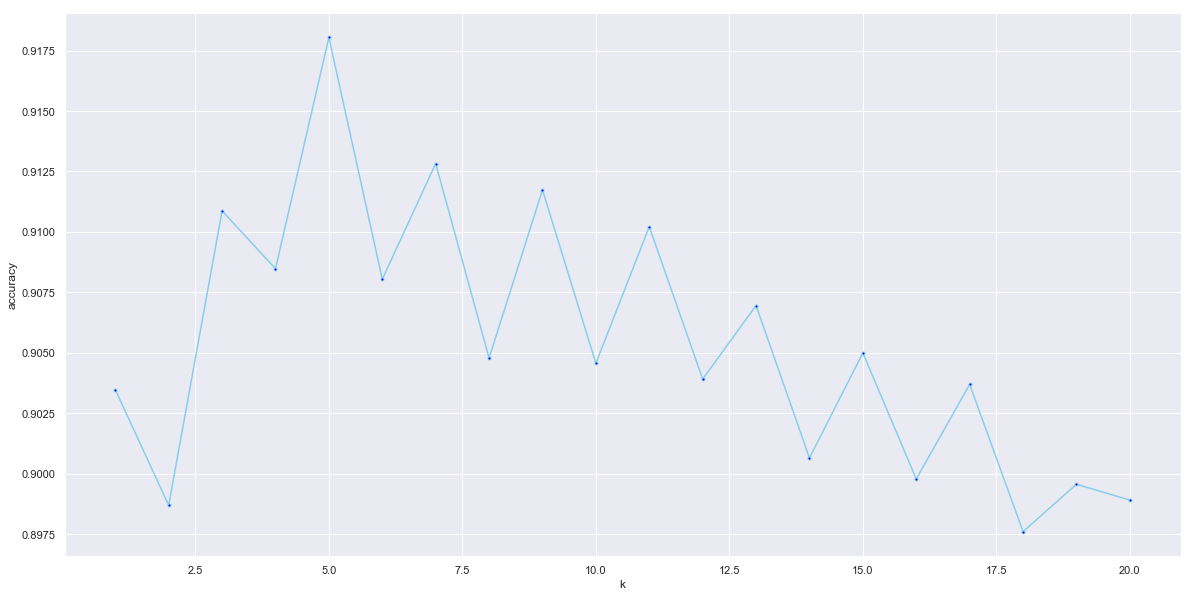

In [17]:
plt.figure(figsize=(20,10))
plt.plot('k', 'accuracy', marker='o', markerfacecolor='blue', markersize=3, data=plot_metric, color='skyblue')
_ = plt.xlabel('k')
_ = plt.ylabel('accuracy')

### Question d

In [18]:
X_array_2 = X_array
added = np.array([1] * 4600).reshape(-1,1)
X_array_2 = np.concatenate((X_array_2, added), axis = 1)
X_array_2[:,54]

array([1, 1, 1, ..., 1, 1, 1])

In [19]:
y_array_2 = y_array
for i in range(len(y_array_2)):
    if y_array_2[i] == 0:
        y_array_2[i] = -1

In [20]:
def derivative(X_train, y_train, w):
    a = 1 / (1 + np.exp(np.multiply(y_train, np.dot(X_train, w))))
    b = np.multiply(y_train, np.multiply(a, X_train))
    return np.sum(b, axis = 0).T.reshape(-1,1)
    

In [21]:
X_train_list, y_train_list, X_test_list, y_test_list = partition(X_array_2, y_array_2)
plot_matrix = np.array(list(range(1,1001))).reshape(-1,1)
for i in range(10):
    X_train, y_train, X_test, y_test = X_train_list[i], y_train_list[i], X_test_list[i], y_test_list[i]
    L_list = []
    w = np.zeros(shape = (55, 1))
    
    for j in range(1000):
        w += (0.01/4600) * derivative(X_train, y_train, w)
        L = np.sum(np.log(1 / (1 + np.exp(-np.multiply(y_train, np.dot(X_train, w))))))
        L_list.append(L)
    
    plot_matrix = np.concatenate((plot_matrix, np.array(L_list).reshape(-1,1)), axis = 1)


In [22]:
plot_df = pd.DataFrame(plot_matrix, columns = ['i', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
plot_df.head()

,i,1,2,3,4,5,6,7,8,9,10
0,1.0,-2194.432933,-2185.091389,-2176.689250,-2185.494556,-2175.631266,-2196.952330,-2196.369409,-2169.708383,-2183.827390,-2186.188535
1,2.0,-2012.873519,-1999.958288,-1997.142946,-2003.097188,-1992.465012,-2013.312481,-2009.905712,-1985.396659,-2001.816095,-2007.001083
2,3.0,-1893.764770,-1879.055821,-1879.422153,-1883.945688,-1872.339351,-1892.816323,-1888.135163,-1865.015917,-1882.720836,-1888.671986
3,4.0,-1807.233696,-1791.395281,-1793.886737,-1797.548998,-1785.020149,-1805.221553,-1799.827483,-1777.805224,-1796.393403,-1802.219343
4,5.0,-1740.383314,-1723.746020,-1727.810156,-1730.893068,-1717.532659,-1737.523022,-1731.657568,-1710.566358,-1729.845225,-1735.156910


In [1]:
plt.figure(figsize=(20,10))
plt.plot('i', '1', data = plot_df)
plt.plot('i', '2', data = plot_df)
plt.plot('i', '3', data = plot_df)
plt.plot('i', '4', data = plot_df)
plt.plot('i', '5', data = plot_df)
plt.plot('i', '6', data = plot_df)
plt.plot('i', '7', data = plot_df)
plt.plot('i', '8', data = plot_df)
plt.plot('i', '9', data = plot_df)
plt.plot('i', '10', data = plot_df)
_ = plt.legend()
_ = plt.xlabel('Iteration')
_ = plt.ylabel('L')

NameError: name 'plt' is not defined

### Question e

In [24]:
def second_derivative(X_train, y_train, w):
    agge = np.zeros(shape = (55,55))
    for m in range(0, X_train.shape[0]):
        a =  1 / (1 + np.exp(-np.dot(X_train[m], w)))
        b = -1 / (1 + np.exp(np.dot(X_train[m], w)))
        agge += a * b * np.outer(X_train[m], X_train[m])
    return agge

In [25]:
X_train_list, y_train_list, X_test_list, y_test_list = partition(X_array_2, y_array_2)
plot_matrix = np.array(list(range(1,101))).reshape(-1,1)
w_list = []
for i in range(10):
    X_train, y_train, X_test, y_test = X_train_list[i], y_train_list[i], X_test_list[i], y_test_list[i]
    L_list = []
    w = np.zeros(shape = (55, 1))
    
    for j in range(100):
        w -= np.dot(derivative(X_train, y_train, w).T, np.linalg.inv(second_derivative(X_train, y_train, w))).T
        L = np.sum(np.log(1 / (1 + np.exp(-np.multiply(y_train, np.dot(X_train, w))))))
        L_list.append(L)
    
    w_list.append(w)
    
    plot_matrix = np.concatenate((plot_matrix, np.array(L_list).reshape(-1,1)), axis = 1)


In [26]:
plot_df = pd.DataFrame(plot_matrix, columns = ['i', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
plot_df.head()

,i,1,2,3,4,5,6,7,8,9,10
0,1.0,-1491.198254,-1473.612863,-1502.796639,-1508.441824,-1495.467039,-1501.240921,-1492.005200,-1498.232571,-1502.133046,-1483.842769
1,2.0,-1154.180434,-1141.969971,-1175.064311,-1180.065633,-1166.813756,-1172.946927,-1161.634020,-1173.918754,-1178.207817,-1153.230947
2,3.0,-1003.063707,-988.098020,-1022.920169,-1025.074027,-1015.073098,-1023.039810,-1010.565841,-1024.409225,-1027.567356,-1000.972491
3,4.0,-925.097386,-902.597802,-938.610618,-939.545174,-930.501879,-941.183000,-929.242746,-940.124037,-944.435699,-914.611830
4,5.0,-887.849712,-866.635766,-900.705519,-900.277301,-891.758038,-903.775908,-885.577997,-900.962334,-907.469879,-875.305947


/Users/panzichen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Second argument '1' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  
/Users/panzichen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Second argument '2' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/panzichen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Second argument '3' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  after removing the cwd from sys.path.
/Users/panzichen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Second argument '4' is ambiguous: c

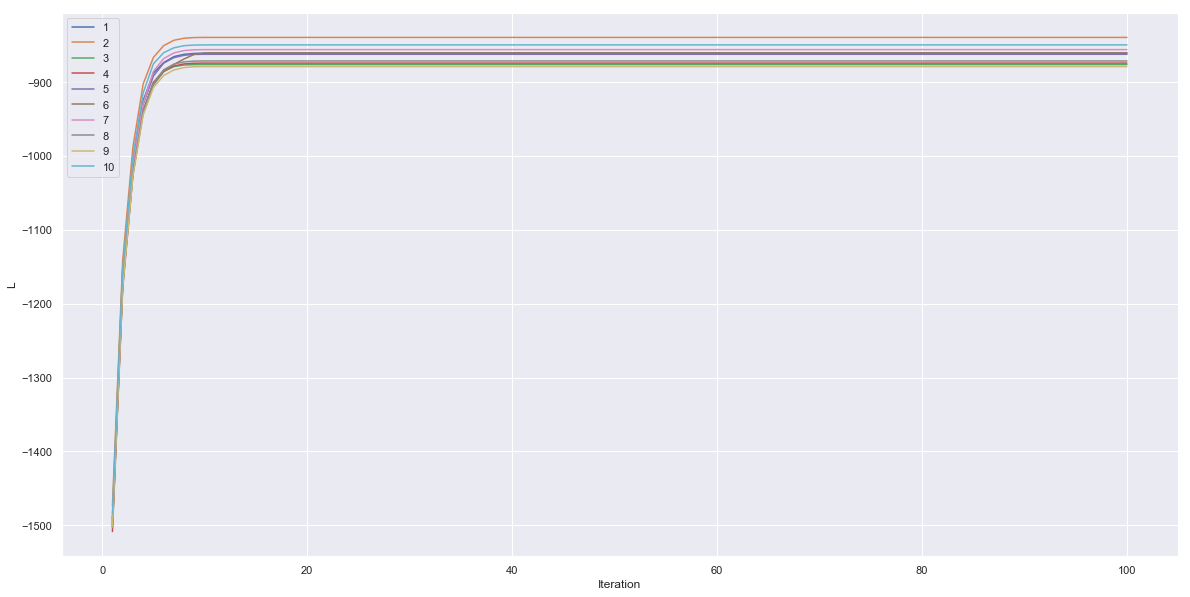

In [27]:
plt.figure(figsize=(20,10))
plt.plot('i', '1', data = plot_df)
plt.plot('i', '2', data = plot_df)
plt.plot('i', '3', data = plot_df)
plt.plot('i', '4', data = plot_df)
plt.plot('i', '5', data = plot_df)
plt.plot('i', '6', data = plot_df)
plt.plot('i', '7', data = plot_df)
plt.plot('i', '8', data = plot_df)
plt.plot('i', '9', data = plot_df)
plt.plot('i', '10', data = plot_df)
_ = plt.legend()
_ = plt.xlabel('Iteration')
_ = plt.ylabel('L')

### Question f

In [28]:
TP_list = []
TN_list = []
FP_list = []
FN_list = []
lamda_list = []

for i in range(10):
    X_train, y_train, X_test, y_test = X_train_list[i], y_train_list[i], X_test_list[i], y_test_list[i]
    w = w_list[i]
    prob_1 = 1 / (1 + np.exp(-np.dot(X_test, w))).reshape(-1,1)
    y_predict = np.zeros(shape = (460,1))
    
    # prob > 0.5 :  -> 1
    for j in range(prob_1.shape[0]):
        if prob_1[j][0] > 0.5: y_predict[j][0] = 1
        else: y_predict[j][0] = -1
    
    metric = pd.DataFrame(np.concatenate((y_test, y_predict), axis = 1), columns = ['y', 'y_predict'])
    
    # calculate TP, TN, FP, FN
    TP = len(metric[(metric['y'] == 1) & (metric['y_predict'] == 1)])
    TN = len(metric[(metric['y'] == -1) & (metric['y_predict'] == -1)])
    FP = len(metric[(metric['y'] == -1) & (metric['y_predict'] == 1)])
    FN = len(metric[(metric['y'] == 1) & (metric['y_predict'] == -1)])
    TP_list.append(TP)
    TN_list.append(TN)
    FP_list.append(FP)
    FN_list.append(FN)
    
TP = np.sum(TP_list)
TN = np.sum(TN_list)
FP = np.sum(FP_list)
FN = np.sum(FN_list)
assert TP + TN + FP + FN == 4600
accuracy = (TP + TN) / 4600
print("TP, TN, FP, FN, accuracy", TP, TN, FP, FN, accuracy)

TP, TN, FP, FN, accuracy 1604 2643 144 209 0.9232608695652174
